<a href="https://colab.research.google.com/github/adampotton/MDM3-Rep-3/blob/main/S2_CNN_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import numpy as np
from google.colab import files, drive
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load NumPy arrays and convert labels array to a numbered labels array

In [3]:
train_images = np.load('/content/drive/My Drive/S2 Data/train_images.npy')
train_names = np.load('/content/drive/My Drive/S2 Data/train_labels.npy')
test_images = np.load('/content/drive/My Drive/S2 Data/test_images.npy')
test_names = np.load('/content/drive/My Drive/S2 Data/test_labels.npy')
val_images = np.load('/content/drive/My Drive/S2 Data/val_images.npy')
val_names = np.load('/content/drive/My Drive/S2 Data/val_labels.npy')

tree_names, train_labels = np.unique(train_names, return_inverse=True)
tree_names, test_labels = np.unique(test_names, return_inverse=True)
tree_names, val_labels = np.unique(val_names, return_inverse=True)

train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)
val_images = val_images.astype(np.float32)


#### Create Data Loaders


In [98]:
# Convert NumPy arrays to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
val_images_tensor = torch.tensor(val_images, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

batch_size = 80

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#### Define the Model, and other paramaeters

In [99]:

num_channels = 12
num_classes = 19
learning_rate = 0.001

model = nn.Sequential(
    nn.Conv2d(num_channels, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 1 * 1, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=3)

#### Train, test, and validate, plotting validation loss

Validation accuracy after 10 epochs: 29.78%
Validation accuracy after 20 epochs: 31.23%
Validation accuracy after 30 epochs: 33.17%
Validation accuracy after 40 epochs: 38.98%
Validation accuracy after 50 epochs: 38.98%
Validation accuracy after 60 epochs: 37.05%
Validation accuracy after 70 epochs: 39.47%
Validation accuracy after 80 epochs: 40.19%
Validation accuracy after 90 epochs: 38.74%
Validation accuracy after 100 epochs: 39.23%
Validation accuracy after 110 epochs: 39.95%
Validation accuracy after 120 epochs: 41.65%
Validation accuracy after 130 epochs: 40.68%
Validation accuracy after 140 epochs: 41.89%
Validation accuracy after 150 epochs: 40.92%
Validation accuracy after 160 epochs: 40.19%
Validation accuracy after 170 epochs: 40.68%
Validation accuracy after 180 epochs: 41.65%
Validation accuracy after 190 epochs: 40.44%
Validation accuracy after 200 epochs: 41.16%
Validation accuracy after 210 epochs: 40.19%
Validation accuracy after 220 epochs: 40.92%
Validation accuracy

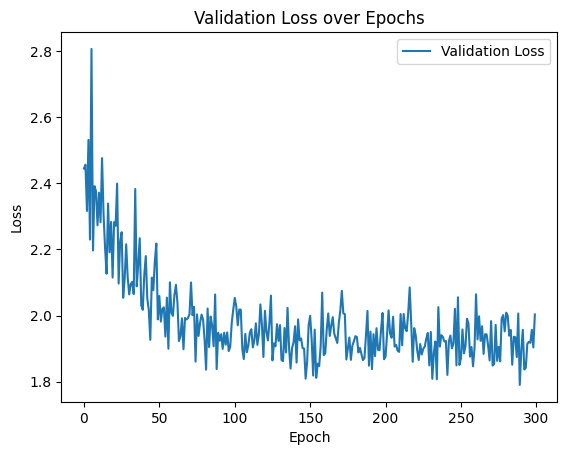

In [101]:
def train():
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images.permute(0, 3, 1, 2))

        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def validation(epoch):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images.permute(0, 3, 1, 2))

            loss = criterion(logits, labels)
            val_loss += loss.item()

            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total

        val_loss /= len(test_loader)
        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Validation accuracy after {epoch+1} epochs: {accuracy:.2f}%')
    return val_loss

def test():
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images.permute(0, 3, 1, 2))

            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total
        print(f'Test accuracy {100 * correct / total:.2f}%')


num_epochs = 300
val_losses = []
for epoch in range(num_epochs):
    train()
    val_loss = validation(epoch)
    val_losses.append(val_loss)
test()

plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()